## Clustering the Grounding Sources of LLM-based Answer Engines

Large Language Models (LLMs) are inherently probabilistic. If you pose the same question to an LLM multiple times, you will get slightly different answers nearly every time. Although the LLM will say roughly the same thing(s), it will say them in slightly different ways. That's because LLMs don't formulate a reasoned answer, per se, they simply select the next most likely word based on the statistical patterns that they learned during training. 

One consequence of that statistical process, however, is that it contributes to a well-known problem for LLMs&mdash; hallucinations&mdash;where they confidently generate answers that contain factual inaccuracies or are entirely fabricated.

To address that issue, LLMs use Retrieval-Augmented Generation (RAG). Rather than depending solely on what the model learned during training, RAG allows LLMs to pull in external information—such as search results, knowledge bases, or proprietary documents—and ground their answers in verifiable sources. RAG significantly reduces hallucinations and makes LLM responses more trustworthy.

But this raises an interesting question: Does the probabilistic nature of LLMs and their response extend to the sources that they use to ground their answers? We know that the words will vary, but will the sources vary, too? 

This project explores that question by analyzing Perplexity, one of today's leading AI "answer engines". 

Using unsupervised learning techniques, the analysis will identify whether distinct clusters of sources emerge&mdash;sources that Perplexity uses consistently, sources it uses only occasionally, and sources that appear only rarely or under specific circumstances. 


### Step 1: Gather Data

The dataset is a collection of ~1,000 responses generated by Perplexity. 

One of the goals of this project is to get a sense of the inherent probability in the choice of sources that Perplexity uses to ground its answers. To that end, all queries were designed to focus on a single, well-defined topic, ensuring that changes in cited sources could not be attributed to topic shifts. I chose **"Master of Science, Data Science, online, in-person, master's in data science"**. 

Besides the fact that an online master's in data science is a shared interest for everyone in this program, I chose this topic because it's well-established, well-documented online, and has a diverse set of articles, rankings, reviews, and institutional sources, which should provide a rich test case for source selection patterns. 

#### Query Design

To ensure that the queries cover the topic from multiple perspectives, I came up with a set of aspects for the queries to focus on: 

<table>
<tr>
    <td> how to choose </td><td> feature comparisons </td><td> reviews and ratings </td><td> value for money </td><td> reliability and quality </td>
</tr>
<tr>
    <td> emerging trends </td><td> upcoming releases / innovations </td><td> customer service experiences </td><td> user recommendations </td><td> strengths and weaknesses </td> 
</tr>
<tr>
    <td> expert recommendations </td><td> cancellation policies </td><td> customer satisfaction </td><td> common complaints </td><td> reliability and credibility </td>
</tr>
<tr>
    <td> first-time experiences </td><td> popular options </td><td> social responsibility </td><td> what to look for </td><td> environmental impact </td>
</tr>
</table>

To generate 1,000 responses, I used Perplexity's API (<https://docs.perplexity.ai/getting-started/overview>) and ran the following prompt 250 times, randomly selecting from the above aspects: 

> **"Generate 4 search-engine queries for 'Master of Science, Data Science, online, in-person, master's in data science'. The queries should focus on {aspect}."**

This resulted in a diverse set of queries that focus on same topic scope, which should be sufficient to explore Perplexity's probabilistic behavior in the choice of sources that it cites.

Perplexity's responses include both an answer and the sources that Perplexity used to ground its response as illustrated by these screenshots:

<img src="images/Perplexity Screenshot Answer.png" alt="Plot" width="45%">
<img src="images/Perplexity Screenshot Sources.png" alt="Plot" width="45%">

I separated the dataset into two files: One that contains the queries and their responses, and one that contained the cited sources. Both files are avaialble in my GitHub repository.

In [1]:
import pandas as pd 

# Import the queries/response dataset, which contains the prompts, their aspects, and Perplexity's responses
queries_df = pd.read_csv('./data/cu_queries_responses.csv')

print("Dataframe Columns:", queries_df.columns)

queries_df.info

Dataframe Columns: Index(['query_id', 'query', 'aspect', 'response_id', 'response'], dtype='object')


<bound method DataFrame.info of      query_id                                              query  \
0       13712  accredited in-person data science master's deg...   
1       13901  accredited universities offering master's in d...   
2       13741  advantages and disadvantages of online master'...   
3       13904  affordable in-person data science master's deg...   
4       13760  affordable in-person Master of Science Data Sc...   
..        ...                                                ...   
993     16561  tips for deciding between online and in-person...   
994     16525  top accredited data science master's degrees i...   
995     16556  top online master's in data science reviewed b...   
996     16541  top ranked online master of science data scien...   
997     16531  what to expect from an online master's in data...   

                         aspect  response_id  \
0       reliability and quality        33386   
1              what to look for        33568   
2      

In [2]:
# Import the citations file, which contians the URLs and domains that were cited 
# as well as a response_id that links records to the queries/responses file
citations_df = pd.read_csv('./data/cu_citations.csv')

print("Dataframe Columns:", citations_df.columns)

citations_df.info

Dataframe Columns: Index(['query_id', 'response_id', 'url', 'domain'], dtype='object')


<bound method DataFrame.info of        query_id  response_id  \
0         16327        40034   
1         16468        40210   
2         16376        40157   
3         15888        39652   
4         15885        39633   
...         ...          ...   
12058     16545        40317   
12059     16535        40287   
12060     16540        40296   
12061     16548        40301   
12062     16536        40318   

                                                     url          domain  
0      https://www.mckinsey.com/capabilities/mckinsey...    mckinsey.com  
1      https://www.mckinsey.com/capabilities/mckinsey...    mckinsey.com  
2      https://hai.stanford.edu/ai-index/2025-ai-inde...    stanford.edu  
3      https://hai.stanford.edu/ai-index/2025-ai-inde...    stanford.edu  
4      https://hai.stanford.edu/ai-index/2025-ai-inde...    stanford.edu  
...                                                  ...             ...  
12058  https://graduate.aup.edu/academics/programs/ms...  

### Step 2: Identify an Unsupervised Learning Problem

Our base use case is very simple&mdash;although we'll soon complicate it!

To determine how often Perplexity cites the same sources, we can simply count the number of times&mdash;across ~1,000 reponses&mdash;that each source is cited. The primary distance/similarity metric will be based on this count. And to determine whether there are clusters of citations counts, we can unspervised learning technique techniques. 

There are multiple algorithms that can be used to cluster low-dimensional datasets: k-means, DBSCAN, Gausian mixture models, and more. 

K-means is both simple and effective, so I will use it as baseline for this analysis. Although k-means isn't well suited to problems with hundreds of features or many thousands of samples, my dataset contains very few features&mdash;as few as just one&mdash;and ~1,000 samples, which is well within k-means' scale. 

I will also use head/tail breaks, which we didn't study in class but is a straightforward algorithm that is well-suited for data that are distributed like citation counts (which we'll explore later).

#### Clustering with Confidence Intervals

What makes this analysis particularly interesting is that probablistic nature of LLMs. Because LLM responses vary, we can't use a single result&mdash;or a single set of results&mdash;to deterministically measure an LLM's behavior. Although we can count the number of times that a URL or domain was cited, the probablistic nature of LLMs means that, if we repeated the process, we would likely come up with different results. We need to recognize that our count is an *estimate* of the LLM's "true" behavior. As such, we have to put a confidence interval around it. 

Confidence intervals make clustering more challenging, because the distance between two samples is no longer an absolute number: It's a range of numbers. Fortunately, there are a variety of clustering techiques that take confidence intervals into consideration: 

- In "Clustering Confidence Set" (<https://www.sciencedirect.com/science/article/abs/pii/S0378375808001298>), Nicoleta Serban proposes using the min and max distances between objects, based on their confidence intervals, to cluster objects. 
- In "Bayesian Clustering with Uncertain Data" (<https://pmc.ncbi.nlm.nih.gov/articles/PMC11398681/>), Kath Nicholls, et al, propose using Bayesian techniques. 
- In "Clustering with Confidence: A Binning Approach" (<https://www.stat.cmu.edu/tr/tr870/tr870.pdf>), Rebecca Nugent and Werner Stuetzle propose using boostrap resampling to prune a tree-based algorithms. 

In this analysis, I adapt Nugent and Stuetzle's bootstrap methodology to both k-means and head/tail breaks.

In [3]:
# Load the libraries for the models

# pip install numpy pandas matplotlib scikit-learn scipy
from sklearn.cluster import KMeans
from scipy.stats import bootstrap

### Step 3: Exploratory Data Analysis (EDA)

Inspect, visualize, and clean the data.

First, confirm that there are no duplicate records.

In [4]:
# queries_df
print("Original number of records in queries_df:", queries_df.shape[0])

queries_df = queries_df.drop_duplicates()
print("Number of records in queries_df after dropping duplicates:", queries_df.shape[0])

# citations_df
print("\nOriginal number of records in citations_df:", citations_df.shape[0])

citations_df = citations_df.drop_duplicates()
print("Number of records in citations_df after dropping duplicates:", citations_df.shape[0])

Original number of records in queries_df: 998
Number of records in queries_df after dropping duplicates: 998

Original number of records in citations_df: 12063
Number of records in citations_df after dropping duplicates: 12063


We did end up some duplicate queries (90), but no duplicate responses. 

In [5]:
# check for duplicate records in just the "query" column of queries_df
unique_queries = queries_df.drop_duplicates(subset=["query"])
print("Number of records in unique_queries after dropping duplicates:", unique_queries.shape[0])

unique_responses = queries_df.drop_duplicates(subset=["response"])
print("Number of records in unique_responses after dropping duplicates:", unique_responses.shape[0])

Number of records in unique_queries after dropping duplicates: 918
Number of records in unique_responses after dropping duplicates: 998


Start with some simple summary statistics. How many distinct domains and URLs are in the dataset? How many citations does an LLM response typically contain? 

In [6]:
# count the number of unique domains cited
print("Number of unique domains:", citations_df['domain'].nunique())   

# count the number of unique URLs cited
print("Number of unique URLs:", citations_df['url'].nunique())   

# average number of citations per response
print(f"\nAverage number of citations per response: {citations_df.groupby('response_id').size().mean():.1f}")

# max number of citations per response
print(f"Max number of citations per response: {citations_df.groupby('response_id').size().max():.1f}")

# min number of citations per response
print(f"Min number of citations per response: {citations_df.groupby('response_id').size().min():.1f}")

Number of unique domains: 787
Number of unique URLs: 1863

Average number of citations per response: 12.1
Max number of citations per response: 20.0
Min number of citations per response: 4.0


To generate the data, I randomly selected from the 20 aspects. I did not, however, end up with an even distribution of responses per aspect. 

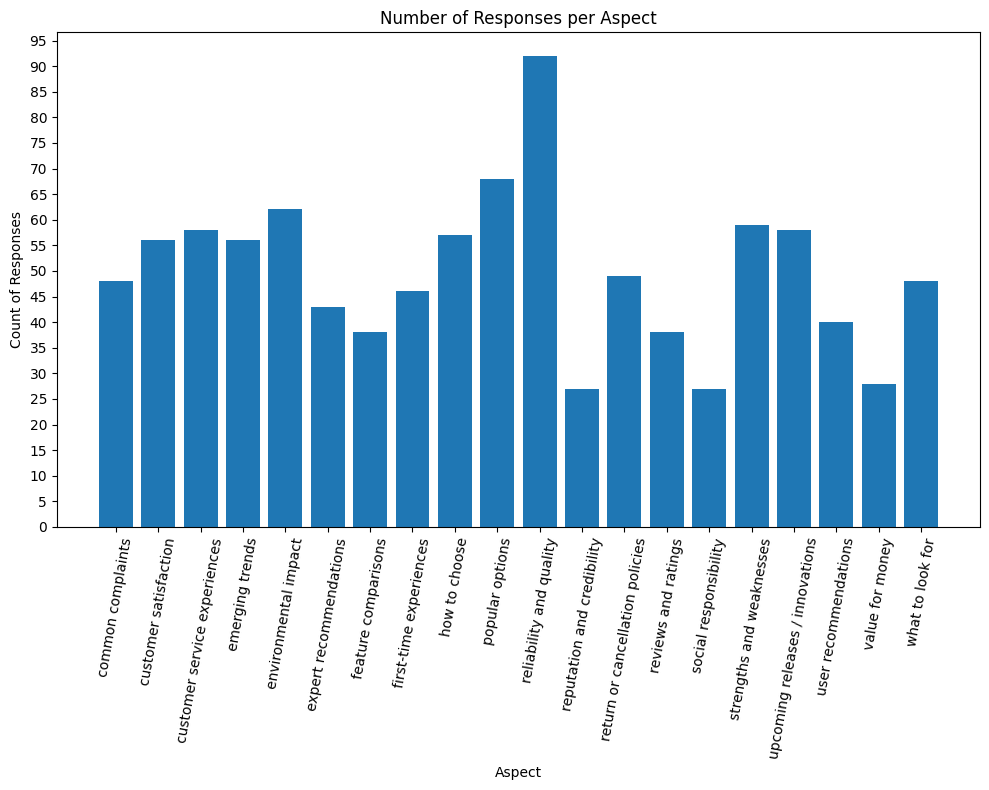

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Count responses per aspect
counts = queries_df['aspect'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 8))
plt.bar(counts.index, counts.values)

plt.title("Number of Responses per Aspect")
plt.xlabel("Aspect")
plt.ylabel("Count of Responses")

# Force y-axis to show integer ticks only
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5))

plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

It's possible that there's a relationship between domains and aspect: A website focused on single topical aspect might get cited for only that aspect. 

To explore that possibility, I looked at the number of times each domain/URL was cited per aspect.  

In [8]:
# add `aspect` to each citation via response_id 
# make sure each response_id maps to a single aspect
aspect_map = (
    queries_df[["response_id", "aspect"]]
    .dropna()
    .drop_duplicates(subset=["response_id"])
)
citations_df = citations_df.merge(
    aspect_map, on="response_id", how="left", validate="many_to_one"
).dropna(subset=["aspect"])

In [9]:
# count each (response_id, domain) once
cit_domain = citations_df.drop_duplicates(subset=["response_id", "domain"])

domain_unique_long = (
    cit_domain.groupby(["aspect", "domain"], dropna=False)["response_id"]
    .nunique()
    .reset_index(name="unique_response_count")
    .sort_values(["aspect", "unique_response_count"], ascending=[True, False])
)

domain_unique = (
    domain_unique_long
    .pivot(index="domain", columns="aspect", values="unique_response_count")
    .fillna(0).astype(int)
)

In [10]:
# count each (response_id, url) once
cit_url = citations_df.drop_duplicates(subset=["response_id", "url"])

url_unique_long = (
    cit_url.groupby(["aspect", "url"], dropna=False)["response_id"]
    .nunique()
    .reset_index(name="unique_response_count")
    .sort_values(["aspect", "unique_response_count"], ascending=[True, False])
)

url_unique = (
    url_unique_long
    .pivot(index="url", columns="aspect", values="unique_response_count")
    .fillna(0).astype(int)
)

In [11]:
def summarize_spread(du: pd.DataFrame) -> pd.DataFrame:
    """
    du: wide table (domain x aspect) with integer counts
    Returns a per-domain summary of multi-aspect spread and concentration.
    """
    totals = du.sum(axis=1)                                  # total unique responses across all aspects
    active_aspects = (du > 0).sum(axis=1)                    # how many aspects cited this domain
    ratio_per_active = totals / active_aspects               # the "citations-to-aspects" ratio
    
    # distribution within the domain across its active aspects
    # probabilities per aspect for each domain
    P = du.div(totals, axis=0).fillna(0.0)
    
    # Shannon entropy & evenness (0..1; 1 = evenly spread across active aspects)
    # guard: log(0) handled by replacing 0*log0 with 0
    ent = -(P.where(P > 0, 1.0).apply(np.log, axis=1) * P).sum(axis=1)
    max_ent = np.log(active_aspects.replace(0, np.nan))
    evenness = (ent / max_ent).fillna(0.0)                   # normalized entropy
    
    # Herfindahl-Hirschman Index (HHI) & dispersion (1 - HHI)
    hhi = (P**2).sum(axis=1)
    dispersion = 1 - hhi                                     # higher = more spread
    
    # dominance: share of the largest aspect for the domain
    dominant_share = du.max(axis=1) / totals
    
    return pd.DataFrame({
        "total_unique_responses": totals.astype(int),
        "active_aspects": active_aspects.astype(int),
        "ratio_per_active": ratio_per_active,                # the suggested metric
        "evenness": evenness,                                # 0..1, uniformity across aspects
        "dispersion": dispersion,                            # 0..(1-1/k)
        "dominant_share": dominant_share                     # 0..1
    }).sort_values(["active_aspects", "total_unique_responses"], ascending=[False, False])



In [12]:
# keep only domains with >1 total unique responses across all aspects
du = domain_unique.copy()
du = du.loc[du.sum(axis=1) > 1]  # drop row-sum == 1

domain_spread = summarize_spread(du)

Below, the histogram shows that&mdash;for domains that were cited more than once&mdash;most were cited in multiple categories.

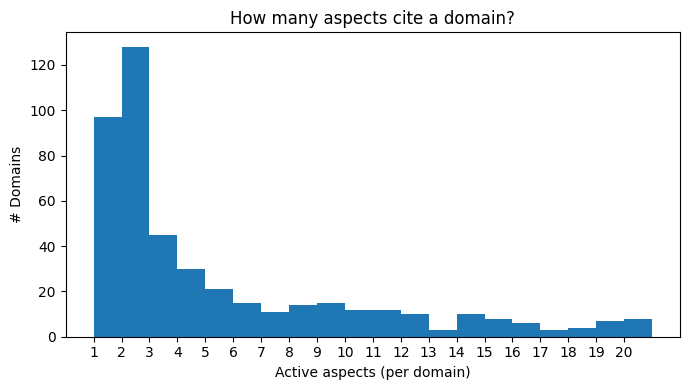

In [13]:
vals = domain_spread["active_aspects"]
max_aspects = vals.max()

plt.figure(figsize=(7,4))
plt.hist(domain_spread["active_aspects"], bins=range(1, domain_spread["active_aspects"].max()+2))
plt.xlabel("Active aspects (per domain)")
plt.ylabel("# Domains")
plt.title("How many aspects cite a domain?")
plt.tight_layout()
plt.xticks(np.arange(1, max_aspects + 1, 1))
plt.show()

A first look at the distribution of citations per URL shows that there is a small number of frequently cited URLs, but most URLs were cited infrequently. 

There are only few breaks in the curve, however, which might make clustering difficult for k-means. 

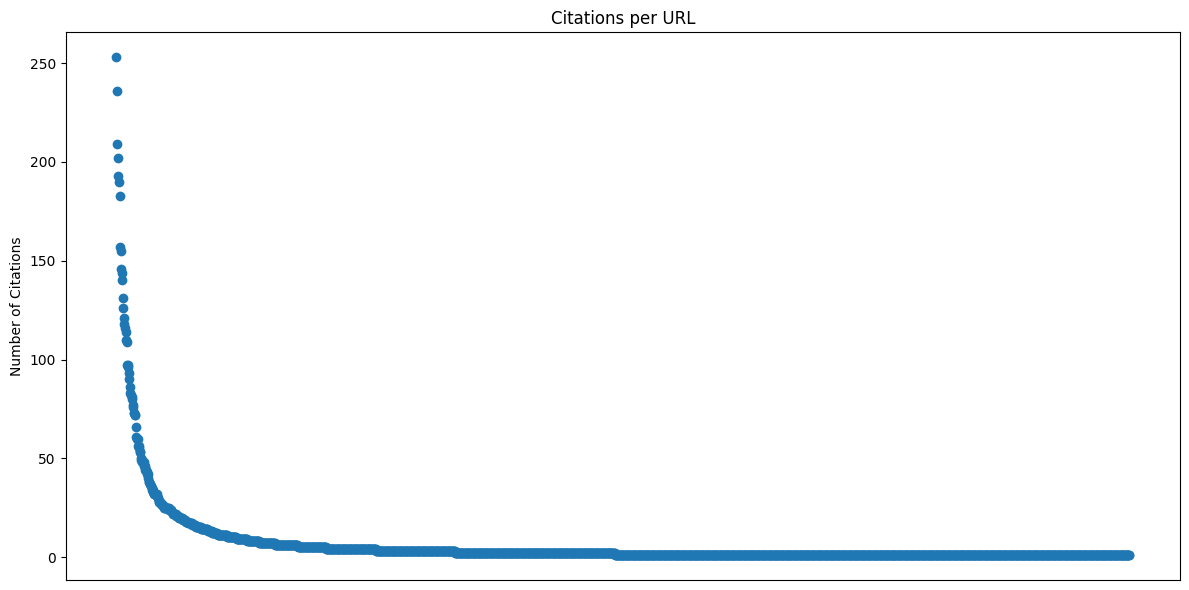

In [14]:
# Count citations per URL and plot the distribution, sorted by descending order     
citation_counts_url = citations_df['url'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
#plt.bar(citation_counts_url.index, citation_counts_url.values)
plt.scatter(citation_counts_url.index, citation_counts_url.values)


plt.title("Citations per URL")
plt.ylabel("Number of Citations")
#plt.xlabel("URL")
plt.xticks([])  # Remove x-axis labels entirely
plt.tight_layout()
plt.show()

The same is true if we count citations by domain.

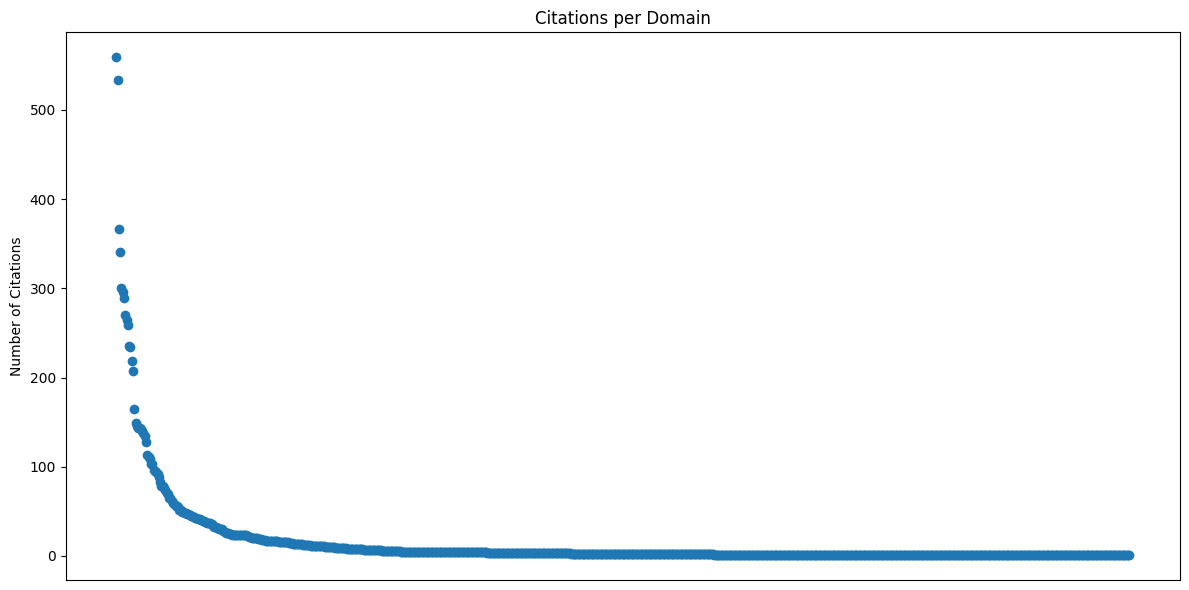

In [15]:
# Count citations per URL and plot the distribution, sorted by descending order     
citation_counts_domain = citations_df['domain'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
#plt.bar(citation_counts_domain.index, citation_counts_domain.values)
plt.scatter(citation_counts_domain.index, citation_counts_domain.values)

plt.title("Citations per Domain")
plt.ylabel("Number of Citations")
#plt.xlabel("domain")
plt.xticks([])  # Remove x-axis labels entirely
plt.tight_layout()
plt.show()

Interestingly, the top domains are virginia.edu (559 citations) and harvard.edu (533), but the top URLs are from different domains: www.eastern.edu/academics/graduate-programs/ms-data-science (253) and cdso.utexas.edu/msds (236). 

Implicitly, virgina.edu and harvard.edu have multiple URLs that get cited, but none as frequently as www.eastern.edu/academics/graduate-programs/ms-data-science or cdso.utexas.edu/msds.

In [16]:
citation_counts_url.head()

url
https://www.eastern.edu/academics/graduate-programs/ms-data-science                                              253
https://cdso.utexas.edu/msds                                                                                     236
https://csweb.rice.edu/academics/graduate-programs/online-mds/blog/online-vs-in-person-master-of-data-science    209
https://datascience.virginia.edu/news/alumni-perspective-do-i-need-masters-degree-data-science                   202
https://extension.harvard.edu/academics/programs/data-science-graduate-program/                                  193
Name: count, dtype: int64

In [17]:
citation_counts_domain.head()

domain
virginia.edu    559
harvard.edu     533
fortune.com     367
coursera.org    341
uchicago.edu    300
Name: count, dtype: int64

`query_id` is an ordinal identifier, so we can determine how many queries it took before a URL/domain appeared in the result set.

In [18]:
# Add an ordinal for each response_id
citations_df = citations_df.sort_values('response_id')
citations_df['response_order'] = pd.factorize(citations_df['response_id'])[0] + 1

# Add response order for each url
citations_df["url_response_order"] = (
    citations_df.groupby(["url"])["response_id"]
      .rank(method="dense", ascending=True)
      .astype(int)
)

# Add response order for each domain
citations_df["domain_response_order"] = (
    citations_df.groupby(["domain"])["response_id"]
      .rank(method="dense", ascending=True)
      .astype(int)
)

Perhaps unsurprisingly, given the probablistic nature of LLMs, new URLs continue to show up even after nearly 1,000 responses. 

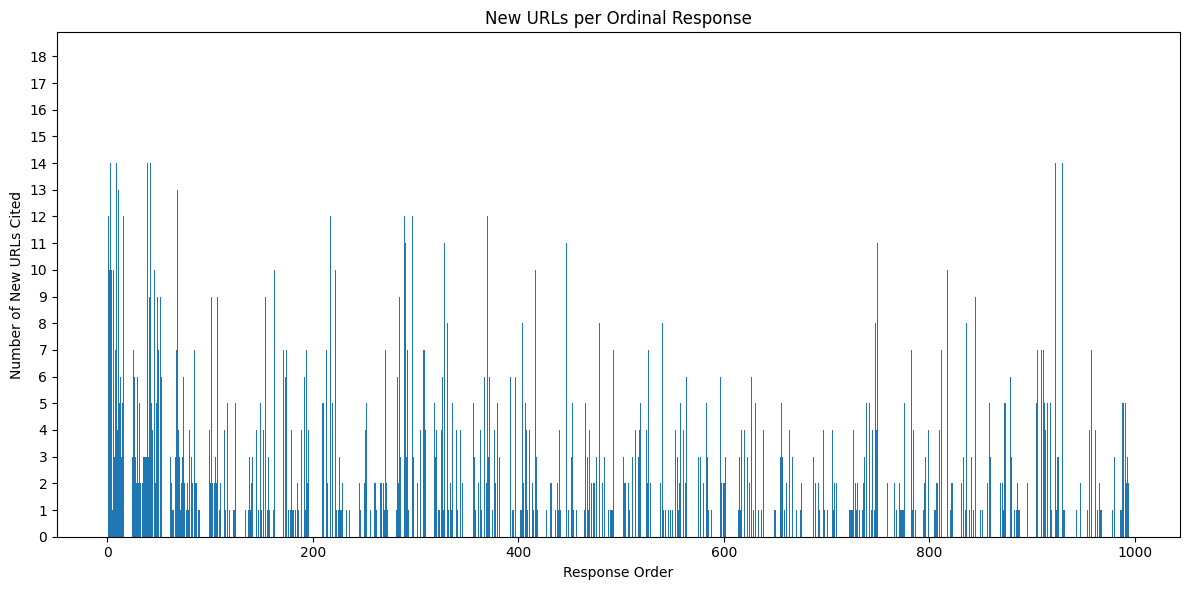

In [19]:
# plot a bar plot of response_order vs url_response_order, filtering to only show url_response_order == 1
filtered_scores = citations_df[citations_df["url_response_order"] == 1]
response_counts_domain = filtered_scores['response_order'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(response_counts_domain.index, response_counts_domain.values)
plt.title("New URLs per Ordinal Response")
plt.ylabel("Number of New URLs Cited")
plt.xlabel("Response Order")
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))
plt.tight_layout()
plt.show()

The same is true of domains.

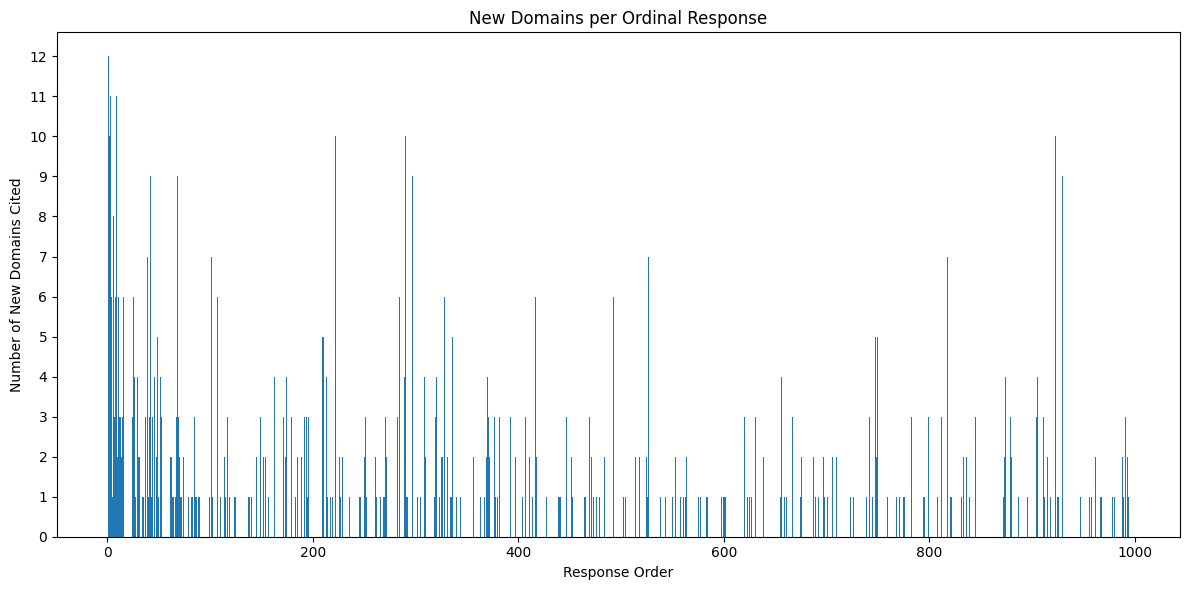

In [20]:
# plot a bar plot of response_order vs domain_response_order, filtering to only show url_response_order == 1
filtered_scores = citations_df[citations_df["domain_response_order"] == 1]
response_counts_domain = filtered_scores['response_order'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(response_counts_domain.index, response_counts_domain.values)
plt.title("New Domains per Ordinal Response")
plt.ylabel("Number of New Domains Cited")
plt.xlabel("Response Order")
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))
plt.tight_layout()
plt.show()

However, if we switch the perspective to look at the total count of citations, based on the first time that a domain was cited, we see that the most frequently cited domains appeared fairly early in the result set.

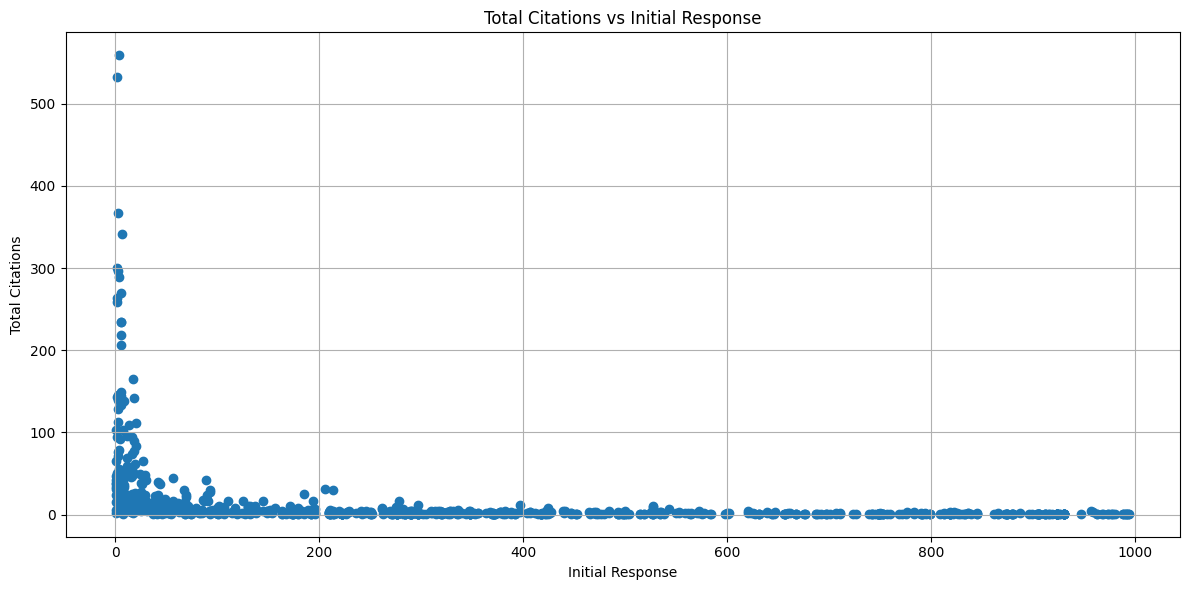

In [21]:
# for each domain in citations_df, calculate the total number of citations and the response order of the initial response order
domain_stats = (
    citations_df.groupby("domain")
    .agg(
        citation_count=("domain", "size"),
        initial_response=("response_order", "min"),
    )
    .reset_index()
)

# plot a scatter plot of initial response order vs total number of citations    
plt.figure(figsize=(12, 6))
plt.scatter(domain_stats["initial_response"], domain_stats["citation_count"])
plt.title("Total Citations vs Initial Response")
plt.xlabel("Initial Response")
plt.ylabel("Total Citations")
plt.grid()
plt.tight_layout()
plt.show()

One way to validate that observation is to rank domains by the number of times they were cited (then by their order of appearance). 

In [22]:
# establish domain rank based on citation_count (desc) and initial_response (asc)

domain_stats = (
    domain_stats
      .sort_values(["citation_count", "initial_response"], ascending=[False, True])
      .assign(domain_rank=lambda d: range(1, len(d) + 1))
)

This function will find the knee in the curve of a plot. (We'll use the same approach to select our *k* for k-means.)

In [23]:
from kneed import KneeLocator
import numpy as np
import pandas as pd

def find_knee(df, x_col="response_order", y_col="citation_count", use_log=True):
    s = df[[x_col, y_col]].dropna().sort_values(x_col).reset_index(drop=True)
    x = s[x_col].to_numpy(dtype=float)
    y = s[y_col].to_numpy(dtype=float)

    if use_log:
        y = np.log1p(y)

    # normalize to [0,1] (helps numerical stability but not strictly required)
    def _minmax(a):
        a0, a1 = np.min(a), np.max(a)
        return (a - a0) / (a1 - a0) if a1 > a0 else np.zeros_like(a)

    xn = _minmax(x)
    yn = _minmax(y)

    k = KneeLocator(xn, yn, curve="convex", direction="decreasing", online=False)
    if k.knee is None:
        return None, "kneedle:none"

    idx = int(np.argmin(np.abs(xn - k.knee)))
    return s.loc[idx, x_col], "kneedle"


In [24]:
# find knee based on domain_rank vs citation_count
knee_x, method_used = find_knee(
    domain_stats,
    x_col="domain_rank",
    y_col="citation_count",
    #window=3,
    use_log=False,
    #min_index=2
)

knee_mask = domain_stats["domain_rank"] == knee_x
knee_y = domain_stats.loc[knee_mask, "citation_count"].iat[0]
print("Rank of the knee point:", knee_y)

domain_stats.loc[knee_mask, "domain"].iat[0]

max_response = domain_stats.loc[domain_stats["domain_rank"] <= knee_x, "initial_response"].max()
print("Max initial response up to the knee point:", max_response)

Rank of the knee point: 49
Max initial response up to the knee point: 27


The knee in the curve suggests that most frequently cited domains showed up within the first ~27 responses. 

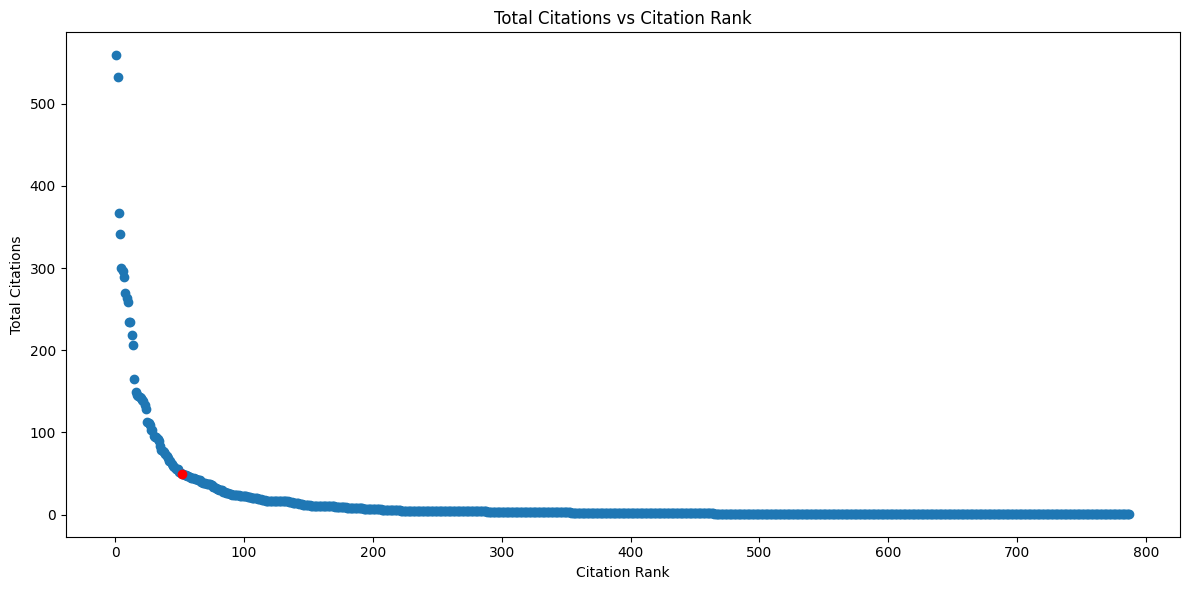

In [25]:
# show a scatter plot of total number of citations vs initial response order
plt.figure(figsize=(12, 6))
plt.scatter(domain_stats["domain_rank"], 
            domain_stats["citation_count"])
plt.title("Total Citations vs Citation Rank")
plt.ylabel("Total Citations")
plt.xlabel("Citation Rank")
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(100))
plt.tight_layout()

mask = domain_stats["domain_rank"].eq(knee_x)
plt.scatter(
    domain_stats.loc[mask, "domain_rank"],
    domain_stats.loc[mask, "citation_count"],
    c="red", label=f"knee_x = {max_response}"
)

plt.show()

Changing the $x$-axis of the scatter plot back to initial response further validates that the most frequently cited domains showed up within the first ~27 responses. 

Although new domains continued to show up regularly throughout the remaining *hundreds* of queries, none was cited as frequently as the domains that showed up early in the result set. 

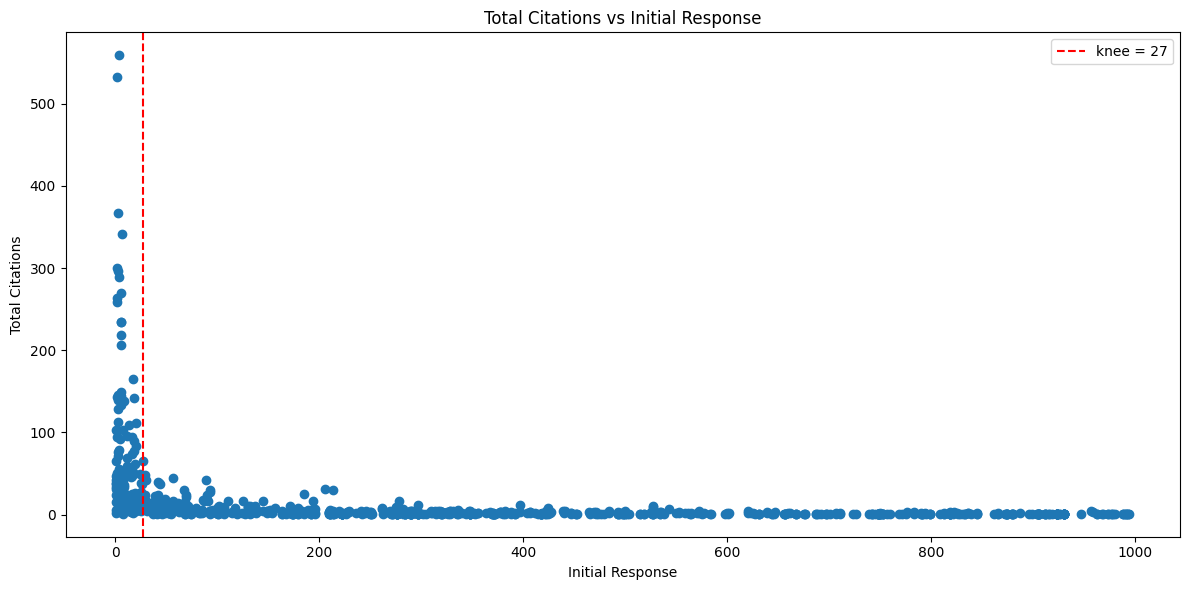

In [26]:
# show a scatter plot of total number of citations vs initial response order
plt.figure(figsize=(12, 6))
plt.scatter(domain_stats["initial_response"], 
            domain_stats["citation_count"])
plt.title("Total Citations vs Initial Response")
plt.ylabel("Total Citations")
plt.xlabel("Initial Response")
if max_response:
    plt.axvline(max_response, linestyle="--", color="red", linewidth=1.5,
                label=f"knee = {max_response}")
    plt.legend()
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(100))
plt.tight_layout()
plt.show()

Note, however, that **Pearson's correlation coefficient** isn't an effective measure because of the non-linear nature of that relationship. 

In [27]:
# correlation between initial_response and citation_count
correlation = domain_stats["initial_response"].corr(domain_stats["citation_count"])
print(f"Correlation between initial_response and citation_count: {correlation:.4f}")

Correlation between initial_response and citation_count: -0.3139


#### Statistical Distributions

As interesting as it is to explore when domains/URLs first appeared in the result set, it's not useful as a feature. Late in this notebook, I use bootstrapping to deal with the inherent uncertainty in these data. Bootstrapping randomly samples from the avialable responses, reshuffling the initial order that URLs/domains appear, making the original initial order irrelevent.  

The single most feature in the result set is the **citation count**, so it will help to characterize the type of distribution that best represents these data. If the data follow a roughly normal distribution, models that assume symmetry and homoscedasticity (e.g., linear regression or Gaussian mixtures) are suitable. However, heavy-tailed, skewed, or multi-modal data&mdash;common in citation and visibility metrics&mdash;favor non-parametric or clustering-based methods. Recognizing whether variability arises from random noise or structural imbalance helps ensure the chosen algorithms capture genuine signal rather than distributional artifacts.

Based on the plots that we've seen so far, we have two likely choices: 

1. According to *Statistical Distributions* (https://doi.org/10.1002/9780470627242.ch29), the lognormal distribution applies to random variables that are constrained by zero but have a few very large values. 

2. Another possiblity is Zipf's law, which states that "when a set of measured values is sorted in decreasing order, the value of the $n$-th entry is often approximately inversely proportional to $n$" (https://en.wikipedia.org/wiki/Zipf%27s_law). 

Estimating the parameters for both distributions and plotting the fitted curves with the sample data suggests that **Zipf's law** is the better fit. 

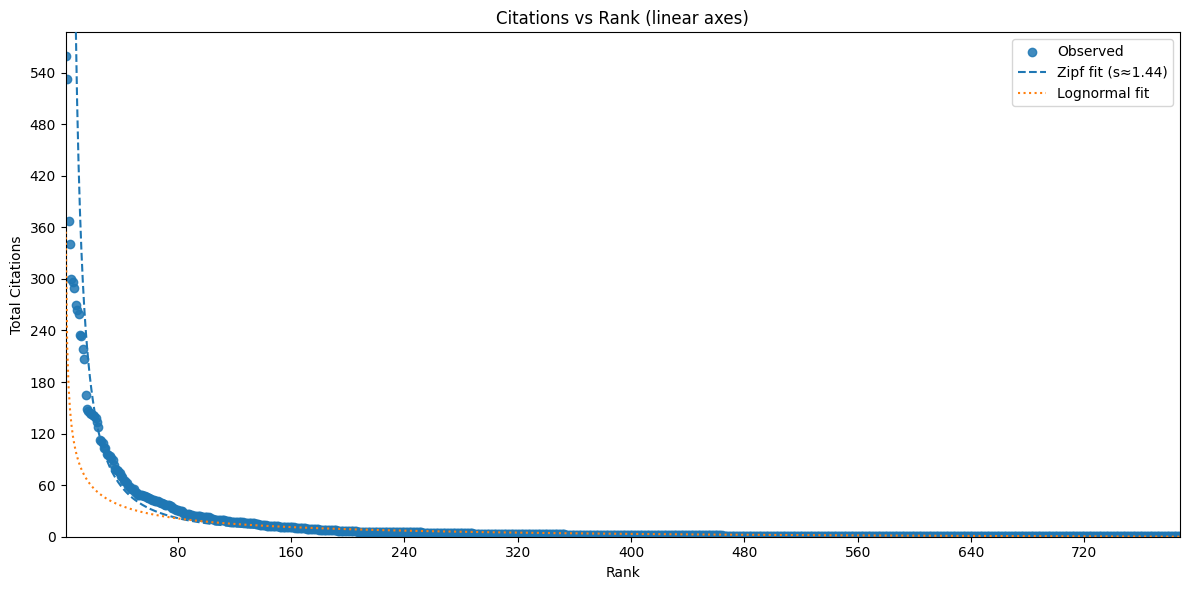

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import norm  # Phi^{-1}

# --- data ---
df = domain_stats.copy()
x = df["domain_rank"].to_numpy()
y = df["citation_count"].to_numpy()


# ---- Zipf fit ----
mask = y > 0
m, b = np.polyfit(np.log(x[mask]), np.log(y[mask]), 1)  # slope m ≈ -s
s = -m
A = np.exp(b)

# Evaluate smooth lines on sorted x to avoid zig-zag
idx = np.argsort(x)
xs = x[idx]
ys = y[idx]
zipf_y = A * (xs ** (-s))

# ---- Lognormal fit over counts ----
y_pos = y[y > 0]
mu = np.log(y_pos).mean()
sigma = np.log(y_pos).std(ddof=0)

n = len(y)  # assumes ranks 1..n; if there are gaps, consider n = x.max()
u = 1.0 - (xs - 0.5) / n
u = np.clip(u, 1e-12, 1 - 1e-12)          # guard against 0/1
lognormal_y = np.exp(mu + sigma * norm.ppf(u))

# ---- Plot ----
plt.figure(figsize=(12, 6))
plt.scatter(x, y, alpha=0.85, label="Observed")
plt.plot(xs, zipf_y, linestyle="--", label=f"Zipf fit (s≈{s:.2f})", zorder=3)
plt.plot(xs, lognormal_y, linestyle=":", label="Lognormal fit", zorder=3)

plt.title("Citations vs Rank (linear axes)")
plt.xlabel("Rank")
plt.ylabel("Total Citations")
plt.xlim(1, xs.max() + 0.5)
plt.ylim(0, y.max() * 1.05)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.tight_layout()
plt.show()


### Data Cleaning

One take-away from the EDA is that the data are already clean: We do not need to remove any records or impute any values. 

However, the data aren't quite ready for modeling: We do need to apply some transforms.

#### Tranforms

The most important transform is calculating confidence intervals for citation counts. 

Despite the fact that we can very precisely count the number of times that domains were cited, we can't think about those counts as fixed values. More appropriately, they're estimates of what we could expect for a sample of 1,000 responses. 

For example, in the data collected for this analysis, Coursera.org was cited 341 times. However, due to the inherent probability of the data-generation and sampling processes, if we repeated the data collection and analysis many times, we would not get *exactly* 341 citations every time. 

In [29]:
domain_stats.loc[domain_stats['domain'] == 'coursera.org', ['domain', 'citation_count']]


,domain,citation_count
154,coursera.org,341


Before modeling, we can apply resampling through bootstrapping to estimate uncertainty in our metrics. Bootstrapping repeatedly samples the data with replacement to create many pseudo-datasets. Each sample produces its own statistic (e.g., mean, centroid, or boundary), and the variability across these estimates forms an empirical distribution. From this, we compute confidence intervals&mdash;typically a 95% confidence level&mdash;without assuming any specific theoretical distribution. This approach quantifies the robustness of our results and communicates how stable the derived metrics are across possible realizations of the data.

#### Confidence Intervals

The tricky thing is that we can't resample individual records: Our sampling unit is an LLM response, so when we resample we randomly select a `response_id` and count all of the citations in that response. 

In [30]:
import numpy as np
import pandas as pd

def bootstrap_citation_counts(
    df: pd.DataFrame,
    group_col: str,                # "domain" or "url"
    unit_col: str,                 # "query_id" or "response_id"
    n_resamples: int = 1000,
    confidence_level: float = 0.95,
    random_state: int | None = None,
):
    """
    Bootstrap CIs for citation *row counts* by `group_col`, resampling units in `unit_col`.

    Returns a DataFrame with:
      [group_col, count, boot_mean, ci_low, ci_high]
    """
    # --- basic checks / cleaning ---
    needed = [group_col, unit_col]
    if missing := [c for c in needed if c not in df.columns]:
        raise KeyError(f"Missing required column(s): {missing}")
    d = df.loc[:, needed].dropna()

    # --- per-unit × group counts (wide) ---
    # rows = unique units, cols = groups (domains/urls), values = counts
    unit_group = (
        d.groupby([unit_col, group_col])
         .size()
         .unstack(fill_value=0)
         .astype(int)
    )
    units = unit_group.index.to_numpy()
    groups = unit_group.columns.to_numpy()
    M, G = unit_group.shape  # M units, G groups

    if M == 0 or G == 0:
        return pd.DataFrame(columns=[group_col, "count", "boot_mean", "ci_low", "ci_high"])

    # point estimate (no resampling): total counts per group
    point_counts = unit_group.sum(axis=0).to_numpy()

    # --- bootstrap over units via multinomial weights ---
    rng = np.random.default_rng(random_state)
    probs = np.full(M, 1.0 / M)

    # Pre-convert to float for matmul
    UG = unit_group.to_numpy(dtype=float)   # shape (M, G)

    # Collect bootstrap samples per group (n_resamples × G)
    # Each resample draws unit weights w ~ Multinomial(M, 1/M),
    # and resampled group counts = w^T @ UG
    samples = np.empty((n_resamples, G), dtype=float)
    for b in range(n_resamples):
        w = rng.multinomial(M, probs)  # length M
        samples[b, :] = w @ UG

    # --- percentile CIs ---
    alpha = 1.0 - confidence_level
    lo_q, hi_q = alpha / 2.0, 1.0 - alpha / 2.0
    ci_low = np.quantile(samples, lo_q, axis=0)
    ci_high = np.quantile(samples, hi_q, axis=0)
    boot_mean = samples.mean(axis=0)

    out = pd.DataFrame({
        group_col: groups,
        "count": point_counts.astype(int),
        "boot_mean": boot_mean,
        "ci_low": ci_low,
        "ci_high": ci_high,
    }).sort_values("count", ascending=False, kind="mergesort").reset_index(drop=True)

    return out


In [31]:
domain_ci = bootstrap_citation_counts(citations_df, group_col='domain', unit_col="response_id", confidence_level = 0.95, random_state = 42)  

In [32]:
import matplotlib.pyplot as plt

def plot_top_domains_with_ci(domain_ci, top_n=10, title="Top Domains with CI"):
    # Take top N by point estimate
    top = domain_ci.nlargest(top_n, "count").copy()
    top = top.sort_values("count", ascending=True)  # sort for horizontal bars

    x = top["count"]
    y = top["domain"]

    # Error bars: distance from point to CI bounds
    lower_err = x - top["ci_low"]
    upper_err = top["ci_high"] - x
    err = [lower_err, upper_err]

    plt.figure(figsize=(8, 5))
    plt.errorbar(
        x, y,
        xerr=err,
        fmt="o",            # point marker
        capsize=4
    )
    plt.xlabel("Citation Count")
    plt.ylabel("Domain")
    plt.title(title)
    plt.grid(axis="x", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()



In the plot below, you can see how Coursera's confidence interval overlaps with both of its immediate neighbors, Fortune.com and UChicago.edu, as well as a number of other domains. The "real" distance between any of these domains might be zero.... And since most unsupervised algorithms&mdash;including k-means&mdash;depend on *exact* distance measures, we'll somehow need to incorporate those intervals into the our models. 


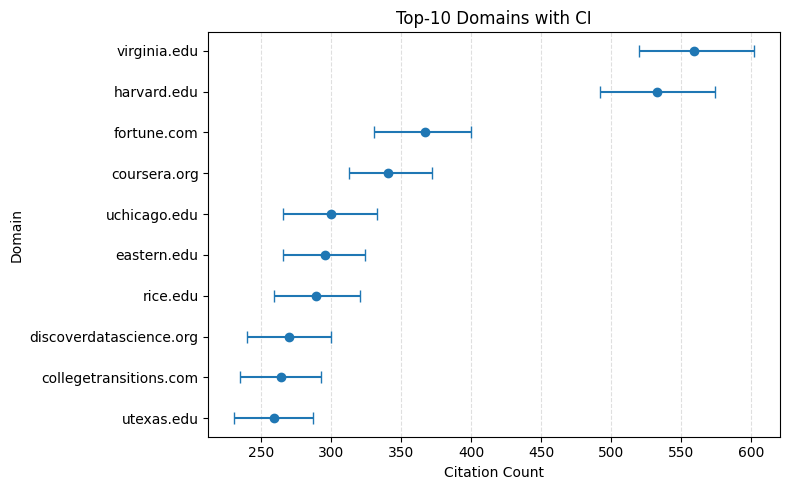

In [33]:
plot_top_domains_with_ci(domain_ci, top_n=10, title="Top-10 Domains with CI")

#### One-hot Encode the Topic Aspect

As a final preprocessing/data-engineering step, we can one-hot encode the topic aspects. Topic aspects might prove useful, because&mdash;again&mdash;some domains/URLs might be specific to a particular aspect of the topic. 

However, I am not going to down-sample the aspects that had more samples than the others. Having a balanced dataset is less important for k-means. As such, the number of samples per `aspect` is reasonably well balanced.  

In [34]:
#  One-Hot encoding 
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=int)
X_ohe = ohe.fit_transform(citations_df[["aspect"]])   # 2D input
aspect_cols = [f"aspect_{c}" for c in ohe.categories_[0]]
citations_ohe = pd.concat(
    [citations_df.drop(columns=["aspect"]), pd.DataFrame(X_ohe, columns=aspect_cols, index=citations_df.index)],
    axis=1
)

### Step 4: Perform Analysis, Present Discussion, and Conclusions

The following section is based on two unsupervised algorithms (**k-means** and **head/tail breaks**) and two approachs (a **standard impementation** and a **bootstrapped implmentation**).

This function, `plot_clusters()`, will be use repeatedly to show cluster assignments. 

In [35]:
def plot_clusters(df,
    x="domain_rank",
    y="citation_count",
    color="cluster",
    title="Domain Clusters",
    figsize=(12, 6),
    s=40,
    alpha=0.9,
    cmap="tab10",
    grid_alpha=0.3,
    show_colorbar=True,
):
    plt.figure(figsize=figsize)

    kwargs = {}
    if color:
        kwargs.update(dict(c=df[color], cmap=cmap))

    sc = plt.scatter(df[x], df[y], s=s, alpha=alpha, **kwargs)

    plt.title(title or f"{y.replace('_',' ').title()} vs {x.replace('_',' ').title()}")
    plt.xlabel(x.replace("_", " ").title())
    plt.ylabel(y.replace("_", " ").title())
    plt.grid(True, alpha=grid_alpha)

    if color and show_colorbar:
        vals = df[color].to_numpy()
        uniq = np.unique(vals[~pd.isna(vals)])
        cbar = plt.colorbar(sc, ticks=np.sort(uniq))
        cbar.set_label(color.replace("_", " ").title())

    plt.tight_layout()
    return sc

#### K-means

The following function, `kmeans_two_pass()` and its helper combine the typical two-step process for fitting k-means:

1. Fit mulitple models across a range of values for *k*, then plot a scree plot to find the inflection point between intertia (the within-cluster sum of squares) and *k*. 
2. Refit a model with the "optimal" *k* from the above step. 

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def _knee_from_scree(ks, inertias):
    x = np.asarray(ks, dtype=float)
    y = np.asarray(inertias, dtype=float)
    x0, y0 = x[0], y[0]; x1, y1 = x[-1], y[-1]
    denom = np.hypot(x1 - x0, y1 - y0)
    if denom == 0:
        return int(x[1]) if len(x) > 1 else int(x[0])
    dist = np.abs((y1 - y0) * x - (x1 - x0) * y + (x1 * y0 - y1 * x0)) / denom
    knee_k = int(x[int(np.argmax(dist))])
    return max(2, knee_k)

def kmeans_two_pass(
    domain_stats: pd.DataFrame,
    feature_cols=("citation_count", "initial_response"),
    k_min=1,
    k_max=10,
    n_init=20,
    random_state=0,
    plot=False
):
    # --- 0) Normalize feature_cols to a list of column names ---
    if isinstance(feature_cols, str):
        feature_cols = [feature_cols]
    else:
        feature_cols = list(feature_cols)

    # Column checks
    missing = [c for c in feature_cols if c not in domain_stats.columns]
    if missing:
        raise KeyError(f"Missing feature column(s): {missing}")

    # --- 1) Data matrix ---
    X_raw = domain_stats.loc[:, feature_cols].astype(float).to_numpy()

    # Edge cases
    n_samples = X_raw.shape[0]
    if n_samples < 2:
        raise ValueError("Need at least 2 samples to run k-means.")
    if k_max > n_samples:
        k_max = n_samples  # cannot have more clusters than samples
    if k_min < 1 or k_min > k_max:
        k_min = 1

    # Drop constant features (optional but safer with 1D)
    col_std = X_raw.std(axis=0)
    keep = col_std > 0
    if not np.any(keep):
        # all features constant → every point identical; force k=1
        k_selected = 1
        km_labels = np.zeros(n_samples, dtype=int)
        centers_df = pd.DataFrame([domain_stats.loc[:, feature_cols].mean().to_list()],
                                  columns=feature_cols).assign(cluster=0)
        out_df = domain_stats.copy()
        out_df["cluster"] = km_labels
        scree_df = pd.DataFrame({"k": [1], "inertia": [0.0]})
        return k_selected, out_df, centers_df, scree_df
    if not np.all(keep):
        # warn silently: drop zero-variance features
        X_raw = X_raw[:, keep]
        feature_cols_kept = [c for c, k in zip(feature_cols, keep) if k]
    else:
        feature_cols_kept = feature_cols

    # --- 2) Standardize ---
    scaler = StandardScaler()
    X = scaler.fit_transform(X_raw)

    # --- 3) Scree curve ---
    ks = list(range(k_min, max(k_min + 1, k_max + 1)))
    inertias = []
    for k in ks:
        if k > n_samples:
            inertias.append(np.nan)
            continue
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        km.fit(X)
        inertias.append(km.inertia_)
    # remove any NaN ks (shouldn't happen with the guard above)
    ks = [k for k, sse in zip(ks, inertias) if np.isfinite(sse)]
    inertias = [sse for sse in inertias if np.isfinite(sse)]

    # --- 4) Choose k by elbow ---
    k_selected = _knee_from_scree(ks, inertias)
    k_selected = min(k_selected, n_samples)  # safety

    # --- 5) Final fit ---
    km_final = KMeans(n_clusters=k_selected, n_init=n_init, random_state=random_state)
    labels = km_final.fit_predict(X)

    # --- 6) Centers back to original units (for kept features) ---
    centers_scaled = km_final.cluster_centers_
    centers_kept = scaler.inverse_transform(centers_scaled)
    centers_df_kept = pd.DataFrame(centers_kept, columns=feature_cols_kept)
    centers_df_kept["cluster"] = np.arange(k_selected)

    # If we dropped any constant features, add them back as their original mean
    if len(feature_cols_kept) != len(feature_cols):
        full_centers = []
        means_full = domain_stats.loc[:, feature_cols].astype(float).mean(axis=0)
        for r in range(k_selected):
            row = {c: (centers_df_kept.loc[r, c] if c in feature_cols_kept else means_full[c])
                   for c in feature_cols}
            row["cluster"] = r
            full_centers.append(row)
        centers_df = pd.DataFrame(full_centers)
    else:
        centers_df = centers_df_kept

    # --- 7) Attach labels & build scree df ---
    out_df = domain_stats.copy()
    out_df["cluster"] = labels
    scree_df = pd.DataFrame({"k": ks, "inertia": inertias})

    # --- 8) Optional plot ---
    if plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6, 4))
        plt.plot(ks, inertias, marker="o")
        plt.xlabel("k"); plt.ylabel("Inertia (within-cluster SSE)")
        plt.title("Scree plot (k-means)")
        plt.grid(True, alpha=0.3)
        if k_selected in ks:
            i = ks.index(k_selected)
            plt.scatter([ks[i]], [inertias[i]], s=120, edgecolor="k")
        plt.show()

    return k_selected, out_df, centers_df, scree_df


##### Run k-means

We'll start with a simple model: We'll fit k-means using just citation counts.

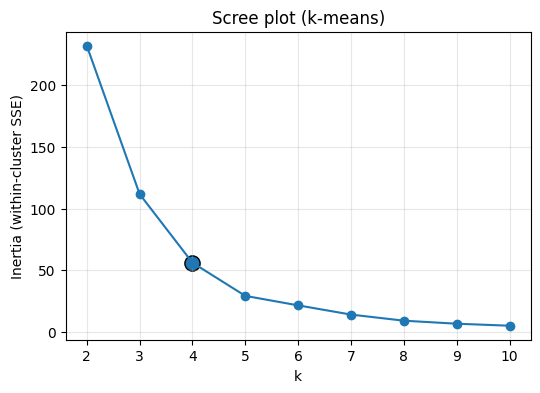

Selected k: 4
   citation_count  cluster
0        5.697422        0
1      273.333333        1
2       97.000000        2
3      546.000000        3


In [37]:
k, clustered_domains, centers, scree = kmeans_two_pass(
    domain_stats,
    feature_cols=("citation_count"),
    k_min=2, 
    k_max=10,
    random_state=42,
    plot=True
)

print("Selected k:", k)
print(centers.sort_values("cluster"))

The result is a model with 4 clusters: 

> | cluster | color | characteristic |
> |:-------:|:------|:--------------|
> | 0 | dark blue | Long-tail Citations |
> | 1 | red | Frequently Cited  |
> | 2 | pink | Sometimes Cited (knee)  |
> | 3 | light blue | Top Domains | 


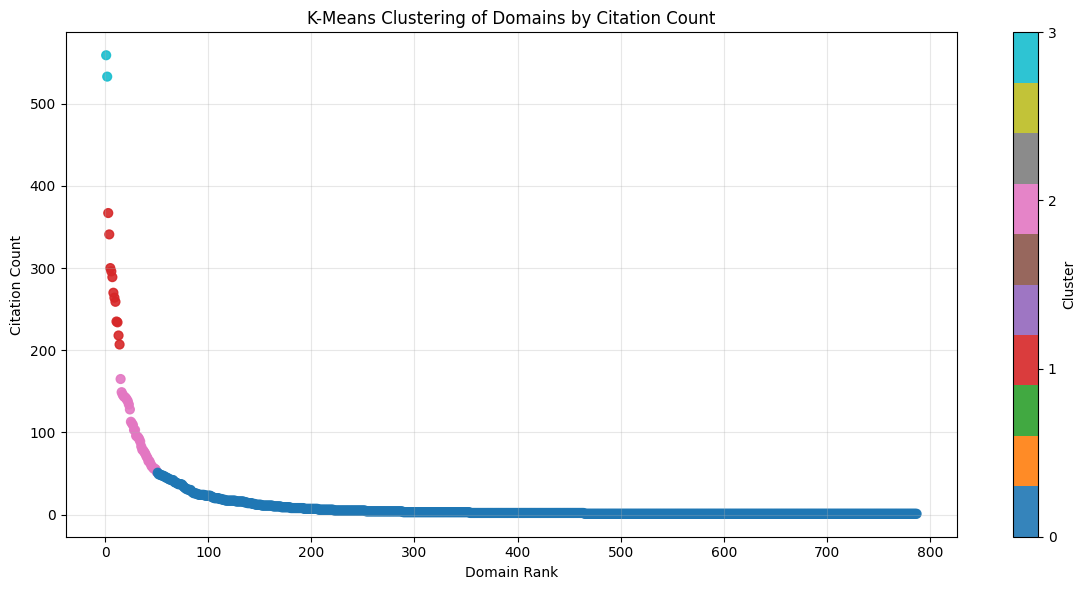

In [38]:
plot_clusters(clustered_domains, 
    x="domain_rank", 
    y="citation_count", 
    color="cluster",
    title="K-Means Clustering of Domains by Citation Count"
)

To see what effect topic aspects have on the model, we can the one-hot encoded features into the model and refit.

In [39]:
# pick the aspect columns
aspect_cols = [c for c in citations_ohe.columns if c.startswith("aspect_")]

# group by domain: count rows + sum each aspect column
domain_stats_ohe = (
    citations_ohe.groupby("domain", dropna=False)
       .agg(citation_count=("domain", "size"),
            **{col: (col, "sum") for col in aspect_cols})
       .reset_index()
       .sort_values("citation_count", ascending=False)
)

# get domain_rank from domain_stats and merge with domain_stats_ohe 
domain_stats_ohe = domain_stats_ohe.merge(
    domain_stats[["domain", "domain_rank"]],
    on="domain",
    how="left"
)

domain_stats_ohe.head()


,domain,citation_count,aspect_common complaints,aspect_customer satisfaction,aspect_customer service experiences,aspect_emerging trends,aspect_environmental impact,aspect_expert recommendations,aspect_feature comparisons,aspect_first-time experiences,...,aspect_reputation and credibility,aspect_return or cancellation policies,aspect_reviews and ratings,aspect_social responsibility,aspect_strengths and weaknesses,aspect_upcoming releases / innovations,aspect_user recommendations,aspect_value for money,aspect_what to look for,domain_rank
0,virginia.edu,559,31,34,38,10,2,26,48,45,...,8,19,11,15,63,19,21,7,32,1
1,harvard.edu,533,10,3,20,48,17,38,4,42,...,8,22,3,14,30,46,27,4,34,2
2,fortune.com,367,7,35,33,16,2,27,7,7,...,15,1,30,0,6,36,25,19,13,3
3,coursera.org,341,14,20,17,9,1,19,10,29,...,7,7,11,4,34,9,20,15,26,4
4,uchicago.edu,300,8,9,17,30,12,7,3,12,...,5,19,3,28,2,43,8,5,18,5


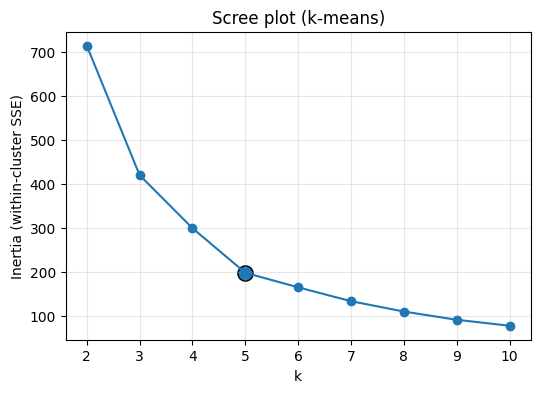

Selected k: 5
   citation_count  aspect_common complaints  cluster
0        5.955163                  0.112772        0
1      361.000000                 29.333333        1
2      120.142857                  1.250000        2
3       50.250000                  8.666667        3
4      328.750000                  7.000000        4


In [40]:
k_ohe, clustered_domains_ohe, centers_ohe, scree_ohe = kmeans_two_pass(
    domain_stats_ohe,
    feature_cols=["citation_count", 'aspect_common complaints'],
    k_min=2, 
    k_max=10,
    random_state=42,
    plot=True
)

print("Selected k:", k_ohe)
print(centers_ohe.sort_values("cluster"))

Incorporating aspects into the model results in the creation of another cluster. However, the clusters are more difficult to characterize by just citation counts. Consider, for example, the natural breaks in the 200-300 citations range: The model actually assigns 3 of the 5 domains to that narrow slice of domains. 

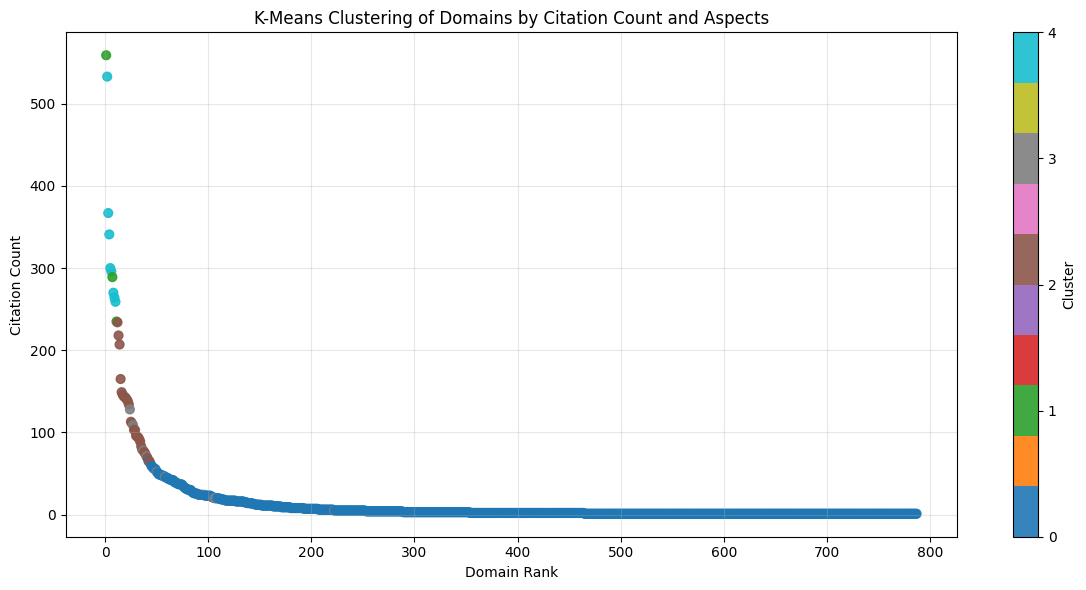

In [41]:
plot_clusters(clustered_domains_ohe, 
    x="domain_rank", 
    y="citation_count", 
    color="cluster",
    title="K-Means Clustering of Domains by Citation Count and Aspects"
)

##### Compare Results

Because we're primarily concerned with citation counts, I will exclude aspects from subsequent models. 

In [42]:
compare = clustered_domains.merge(
    clustered_domains_ohe[["domain", "cluster"]].rename(columns={"cluster": "cluster_ohe"}),
    on="domain",
    how="inner",
    validate="one_to_one"
)

# create a truth table comparing the domain clusters based on k-means and the bootstrapped clusters
truth_table = pd.crosstab(compare["cluster"], compare["cluster_ohe"], rownames=["Counts Cluster"], colnames=["OHE Cluster"], margins=True)

print(truth_table)

OHE Cluster       0  1   2   3  4  All
Counts Cluster                        
0               730  0   0   7  0  737
1                 0  2   3   0  7   12
2                 6  0  25   5  0   36
3                 0  1   0   0  1    2
All             736  3  28  12  8  787


##### Bootstrapped K-means

In standard k-means, cluster centroids are computed from a single pass over the dataset, which can make results sensitive to initialization and sample composition. By bootstrapping k-means, we rerun the algorithm across multiple resampled subsets. Each iteration produces slightly different centroids, and these are later aligned and averaged to reveal stable, consensus cluster centers. The dispersion of these centroids across runs provides confidence intervals for each cluster's position, offering a probabilistic understanding of the clustering structure rather than a single deterministic partition.

In [43]:
from bootstrapped_clustering import bootstrap_kmeans_groups

# domains, resampling by response
# we have to use the raw data here because it needs to be resampled by response_id, and we need every citations within each response
res = bootstrap_kmeans_groups(
    #citations_df,
    citations_ohe, 
    group_col="domain",          # or "url"
    unit_col="response_id",      # or "query_id"
    feature_cols=["citation_count"],
    k_min=2, 
    k_max=10,
    n_boot=500,
    confidence_level=0.95,
    random_state=42
)

print("Selected k:", res["k"])
display(res["memberships"].head())    # per-domain: MAP cluster + membership probabilities
display(res["centers"])               # cluster centers with bootstrap CIs (original units)
display(res["scree"])                 # elbow curve used for k selection

Selected k: 4


,domain,cluster,max_prob,p_cluster_0,p_cluster_1,p_cluster_2,p_cluster_3
0,1stepgrow.com,0,1.0,1.0,0.0,0.0,0.0
1,2030.builders,0,1.0,1.0,0.0,0.0,0.0
2,4geeksacademy.com,0,1.0,1.0,0.0,0.0,0.0
3,aamc.org,0,1.0,1.0,0.0,0.0,0.0
4,abet.org,0,1.0,1.0,0.0,0.0,0.0


,cluster,feature,mean,ci_low,ci_high
0,0,citation_count,4.331605,3.849951,4.788879
1,1,citation_count,172.514309,163.428409,180.210417
2,2,citation_count,344.287667,322.237500,362.262500
3,3,citation_count,60.331982,52.760384,67.860484


,k,inertia
0,2,231.901423
1,3,111.658818
2,4,56.063613
3,5,29.202207
4,6,21.517260
5,7,14.051644
6,8,9.093337
7,9,6.632160
8,10,5.024551


In [44]:
# convert memberships to a dataframe
memberships_df = pd.DataFrame(res["memberships"])

# merge with results of the standard implementation (clustered_domains)
memberships_df = memberships_df.merge(
    clustered_domains.loc[:, ["domain", "citation_count", "domain_rank", "cluster"]].drop_duplicates("domain"),
    on="domain",                 # same column on both sides
    how="left",
    suffixes=("_bootstrapped", "_kmeans"),
    validate="many_to_one"       # many domains in memberships -> one row per domain in right
)

The result is a model with 4 clusters, the same as standard k-mean. The only difference is that two colors, pink and light blue, are swapped (which doesn't mean anything in terms of the clustering results): 

> | cluster | color | characteristic |
> |:-------:|:------|:--------------|
> | 0 | dark blue | Long-tail Citations |
> | 1 | red | Frequently Cited  |
> | 2 | pink | Top Domains |
> | 3 | light blue | Sometimes Cited (knee)  | 

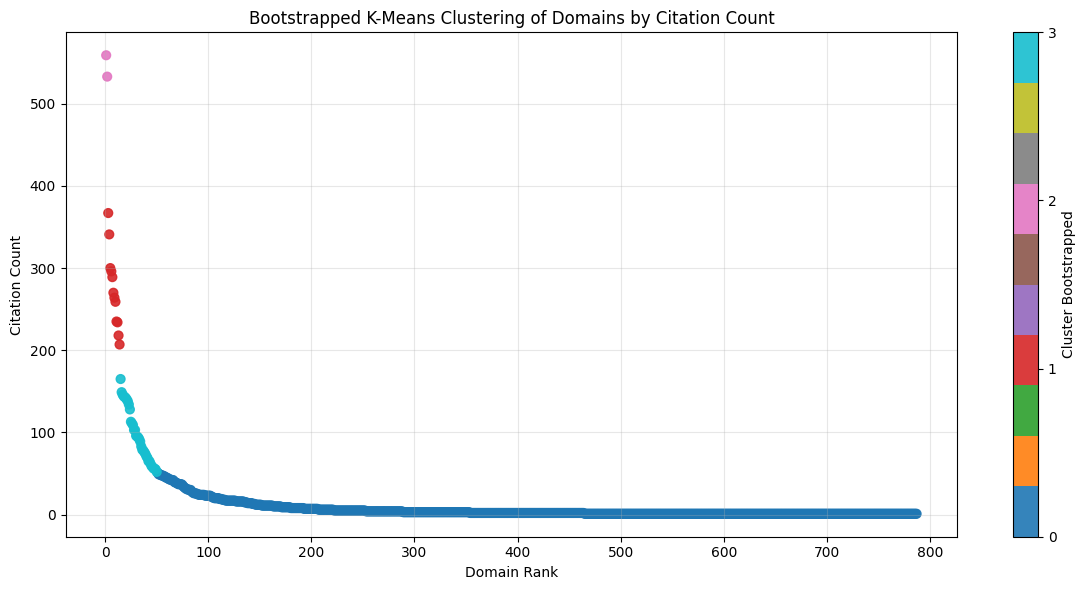

In [45]:
plot_clusters(memberships_df, 
    x="domain_rank", 
    y="citation_count", 
    color="cluster_bootstrapped",            
    title="Bootstrapped K-Means Clustering of Domains by Citation Count"
)

##### Compare results

Remarkably, the standard and bootstrapped implementations produced *identical* results, which is amazing when you consider that the model was refitted with 500 bootstrapped resamples.   

In [46]:
# create a truth table comparing the domain clusters based on k-means and the bootstrapped clusters
truth_table = pd.crosstab(memberships_df["cluster_bootstrapped"], memberships_df["cluster_kmeans"], rownames=["Bootstrapped Cluster"], colnames=["K-means Cluster"], margins=True)

print(truth_table)

K-means Cluster         0   1   2  3  All
Bootstrapped Cluster                     
0                     737   0   0  0  737
1                       0  12   0  0   12
2                       0   0   0  2    2
3                       0   0  36  0   36
All                   737  12  36  2  787


#### Head/tail Breaks

Head/tail breaks is a recursive partitioning algorithm designed for data with heavy-tailed or power-law distributions (https://en.wikipedia.org/wiki/Head/tail_breaks). It repeatedly divides the data into two parts: a "head" (values above the mean) and a "tail" (values below it). The process continues on the head until the data become sufficiently homogeneous. This method naturally reveals hierarchical structure in skewed data, making it particularly effective for identifying tiers or scales of prominence in citation or frequency-like datasets where a small number high-value items dominate the long tail.

In [47]:
import numpy as np
import pandas as pd

def head_tail_breaks(x, min_head_frac=0.4):
    x = np.asarray(x, dtype=float)
    breaks = [x.min()]
    cur = x.copy()
    while True:
        m = cur.mean()
        head = cur[cur > m]
        # stop if head not small enough (no heavy tail) or head empty
        if len(head) == 0 or len(head) / len(cur) > min_head_frac:
            breaks.append(cur.max())
            break
        breaks.append(m)
        cur = head
    return np.unique(np.sort(breaks))


##### Run head/tail breaks

In [48]:
# apply head-tail breaks to domain_stats["citation_count"]
vals = domain_stats["citation_count"].to_numpy()
cuts = head_tail_breaks(vals)                  # e.g., array of breakpoints
labels = pd.cut(vals, bins=cuts, include_lowest=True, labels=False)
domain_stats["htb_bin"] = labels               # discrete classes for plotting or grouping

The result is a model with 5 clusters: 

> | cluster | color | characteristic |
> |:-------:|:------|:--------------|
> | 0 | dark blue | Long-tail Citations |
> | 1 | green | Infrequently Cited (knee) |
> | 2 | brown | Occasionally Cited |
> | 3 | grey | Frequently Cited | 
> | 4 | light blue | Top Domains | 


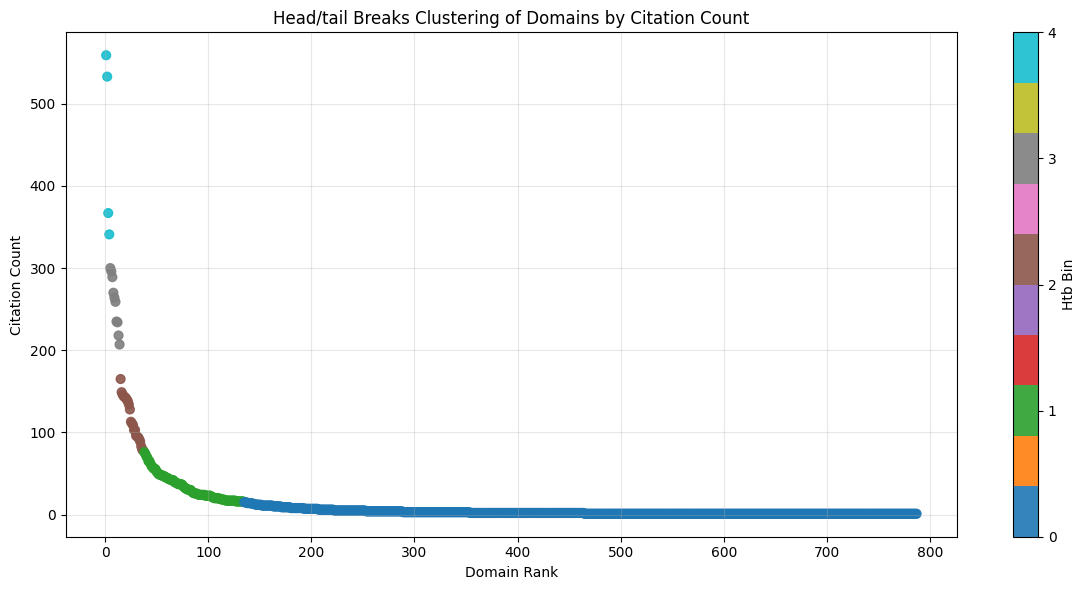

In [49]:
plot_clusters(domain_stats, 
    x="domain_rank", 
    y="citation_count", 
    color="htb_bin",            
    title="Head/tail Breaks Clustering of Domains by Citation Count"
)

##### Bootstrapped Head/tail Breaks

In [50]:
from bootstrapped_clustering import bootstrap_htb_counts_by_unit

res_units = bootstrap_htb_counts_by_unit(
    citations_df,        # row = citation
    group_col="domain",
    unit_col="response_id",
    n_boot=500,
    confidence_level=0.95,
    min_head_frac=0.4,
    random_state=42
)

res_units["memberships"].head()  # p_tier_* per domain + MAP & max_prob
res_units["break_ci"].head()     # CIs for tier boundaries
res_units["tiers_dist"]          # how often we got 2,3,4,... tiers


n_tiers
3     16
4      1
5    383
6    100
Name: count, dtype: int64

In [51]:
# convert memberships to a dataframe
res_memberships_df = pd.DataFrame(res_units["memberships"])

# merge "initial_response" from clustered_domains 
res_memberships_df = res_memberships_df.merge(
    domain_stats.loc[:, ["domain", "domain_rank", "citation_count", "htb_bin"]].drop_duplicates("domain"),
    on="domain",                 # same column on both sides
    how="left",
    suffixes=("_bootstrapped", "_htb"),
    validate="many_to_one"       # many domains in memberships -> one row per domain in right
)

The results are the same 5 clusters as the standard head/tail breaks:

> | cluster | color | characteristic |
> |:-------:|:------|:--------------|
> | 0 | dark blue | Long-tail Citations |
> | 1 | green | Infrequently Cited (knee) |
> | 2 | brown | Sometimes Cited |
> | 3 | grey | Frequently Cited | 
> | 4 | light blue | Top Domains | 

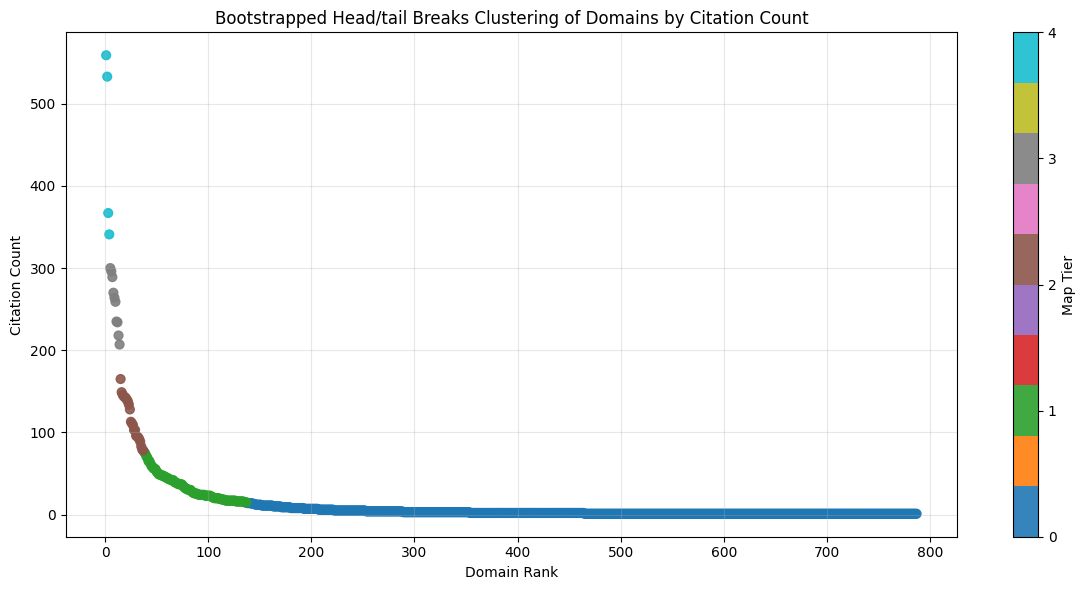

In [52]:
plot_clusters(res_memberships_df, 
    x="domain_rank", 
    y="citation_count", 
    color="map_tier",            
    title="Bootstrapped Head/tail Breaks Clustering of Domains by Citation Count"
)

##### Compare Results

The standard and bootstrapped implementations produced *nearly* identical results. Only two domains moved from the "long-tail" cluster to the "knee" cluster.

In [53]:
# create a truth table comparing the domain clusters based on k-means and the bootstrapped clusters
truth_table = pd.crosstab(res_memberships_df["map_tier"], res_memberships_df["htb_bin"], rownames=["Bootstrapped Cluster"], colnames=["K-means Cluster"], margins=True)

print(truth_table)


K-means Cluster         0   1   2   3  4  All
Bootstrapped Cluster                         
0                     651   0   0   0  0  651
1                       2  97   0   0  0   99
2                       0   0  23   0  0   23
3                       0   0   0  10  0   10
4                       0   0   0   0  4    4
All                   653  97  23  10  4  787



#### K-means vs Head/tail Breaks

Finally, I was curious how the results would compare if I set *k* equal to $5$, the same number of clusters as the head/tail breaks model.

In [54]:
k, clustered_domains, centers, scree = kmeans_two_pass(
    domain_stats,
    feature_cols=("citation_count"),
    k_min=5, 
    k_max=5,
    random_state=42,
    plot=False
)

The results are very similar to head/tail breaks (in a slightly different order):

> | cluster | color | characteristic |
> |:-------:|:------|:--------------|
> | 0 | dark blue | Long-tail Citations |
> | 1 | green | Frequently Cited | 
> | 2 | brown | Top Domains | 
> | 3 | grey | Sometimes Cited |
> | 4 | light blue | Infrequently Cited (knee) |

The are some notable differences: 

- k-means put only 2 domains into a top cluster; head/tail breaks included 4 domains.
- k-means had a smaller "knee" cluster (67 domains) than head/tail breaks (99 domains), so its long-tail cluster starts earlier (rank ≈ 100) than it did for head/tail breaks (rank ≈ 150). 

However, these differences are relatively subtle: In the absence of specific use-case requirements, there is no "better" model. 

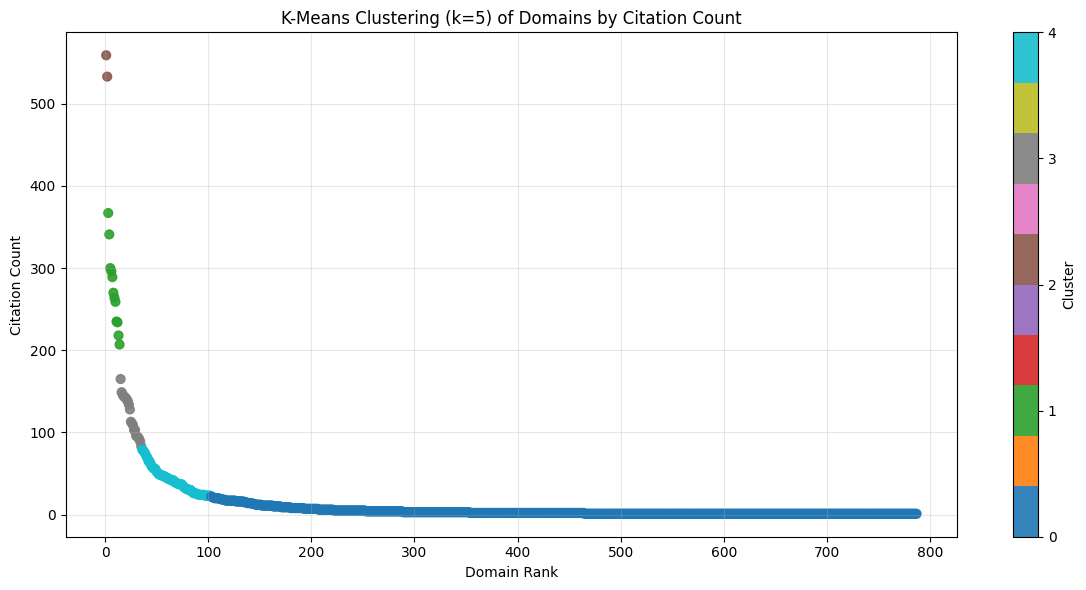

In [55]:
plot_clusters(clustered_domains, 
    x="domain_rank", 
    y="citation_count", 
    color="cluster",
    title="K-Means Clustering (k=5) of Domains by Citation Count"
)

In [56]:
# merge "initial_response" from clustered_domains 
res_memberships_df = res_memberships_df.merge(
    clustered_domains.loc[:, ["domain", "cluster"]].drop_duplicates("domain"),
    on="domain",                 # same column on both sides
    how="left",
    validate="many_to_one"       # many domains in memberships -> one row per domain in right
)

In [57]:
# create a truth table comparing the domain clusters based on k-means and the bootstrapped clusters
truth_table = pd.crosstab(res_memberships_df["map_tier"], res_memberships_df["cluster"], rownames=["Bootstrapped HTB"], colnames=["K-means Cluster"], margins=True)

print(truth_table)

K-means Cluster     0   1  2   3   4  All
Bootstrapped HTB                         
0                 651   0  0   0   0  651
1                  34   0  0   0  65   99
2                   0   0  0  21   2   23
3                   0  10  0   0   0   10
4                   0   2  2   0   0    4
All               685  12  2  21  67  787


### Conclusion

A few key take-aways:

1. The probabilistic nature of Large Language Models (LLMs) extends to the sources they cite: A small number of source clearly get cited more frequently than others, but a long tail of new sources continue to appear even after 1,000 responses.  

2. Because LLMs are probabilistic, the exact number of citations that any source will receive is inherently uncertain. Confidence intervals allows us to quantify that uncertainty. 

3. Bootstrap resampling can use can be extended to unsupervised learning methods. Despite the uncertainty in our sample dataset, bootstrapped k-means and head/tail breaks were both able to reveal stable structures in the data, consistently recovering a small number of meaningful clusters.

4. The consistency between traditional and bootstrapped results suggest that clustering is less sensitive to uncertainty than raw counts. One likely reason is that clustering operates on aggregated patterns rather than exact values, and while bootstrapped samples result in slightly different citation counts, the "distance" between domains remains relatively stable. 

By grouping cited sources into clusters, we’re effectively coarsening the granularity of the analysis, but the result is a more stable and interpretable view of the sources that LLMs rely on. The resulting clusters often correspond to domains whose citation frequencies share overlapping confidence intervals, suggesting that they occupy similar roles in the model's information landscape. Ultimately, clustering offers a robust and probabilistically 
aware framework for understanding how LLMs ground their responses and how their citation patterns evolve over time.
